In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix
from lightgbm import LGBMClassifier
import hyperopt
from hyperopt import hp
import joblib
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Specify the type of features to use: either all metrics or derived indicators
DEMorAll = "AllMetrics"  # Options: DemDerivedIndicators OR AllMetrics

# Load the dataset
filepath="/content/drive/MyDrive/Dataset/1844Points.csv"
data01 = pd.read_csv(filepath, encoding='gbk')

# Rename columns for better understanding
data01.columns = ['FID', 'X', 'Y', 'Aspect', 'Elevation', 'Distance to lineament', 'Lineament density',
                  'NDVI', 'Plan curvature', 'Profile curvature', 'Slope', 'Slope length', 'STI',
                  'SPI', 'TPI', 'TWI', 'VRM', 'LULC', 'Habitat', 'GDP',
                  'Distance from River', 'Distance from Road', 'target']

# Drop unnecessary columns based on the selected feature type
columns_to_drop = ['FID', 'X', 'Y'] if DEMorAll == 'AllMetrics' else ['FID', 'X', 'Y',
                                                                     'LULC', 'Habitat', 'GDP', 'NDVI', 'Distance from Road']
data01.drop(columns=columns_to_drop, inplace=True)  # Remove specified columns from the dataset




# Define output file and model paths
filename = '/content/outputt\light_{}.txt'.format(DEMorAll)
model_path = '/content/output\light_{}.model'.format(DEMorAll)

max_evals = 10  # Number of evaluations for hyperparameter tuning
seed = 4  # Random seed for reproducibility
n_splits = 4  # Number of folds for K-Fold cross-validation

In [ ]:
# Save the column names
header = data01.columns.tolist()

# Split the dataset into two dataframes based on the target value
data_0 = data01.loc[data01['target'] == 0]  # Rows with target = 0
data_1 = data01.loc[data01['target'] == 1]  # Rows with target = 1

# Split target = 0 data into 80% training and 20% validation sets
data_0_X = data_0.drop(columns=["target"], axis=1)
data_0_Y = data_0.target
train_0_X, valid_0_X, train_0_y, valid_0_y = train_test_split(data_0_X, data_0_Y, test_size=0.2, random_state=seed)
save_TrainDate_0 = pd.DataFrame(np.column_stack([train_0_X, train_0_y]), columns=header)
save_ValidDate_0 = pd.DataFrame(np.column_stack([valid_0_X, valid_0_y]), columns=header)

# Split target = 1 data into 80% training and 20% validation sets
data_1_X = data_1.drop(columns=["target"], axis=1)
data_1_Y = data_1.target
train_1_X, valid_1_X, train_1_y, valid_1_y = train_test_split(data_1_X, data_1_Y, test_size=0.2, random_state=seed)
save_TrainDate_1 = pd.DataFrame(np.column_stack([train_1_X, train_1_y]), columns=header)
save_ValidDate_1 = pd.DataFrame(np.column_stack([valid_1_X, valid_1_y]), columns=header)

# Combine training datasets and shuffle the data to avoid ordering bias
train_date = pd.concat([save_TrainDate_0, save_TrainDate_1])
train_date = train_date.sample(frac=1, random_state=42)

# Combine validation datasets and shuffle the data to avoid ordering bias
valid_date = pd.concat([save_ValidDate_0, save_ValidDate_1])
valid_date = valid_date.sample(frac=1, random_state=42)

# Separate features (X) and target (y) from the training dataset
train_y = train_date.target
train_X = train_date.drop(columns=[ "target"], axis=1)

# Separate features (X) and target (y) from the validation dataset
valid_y = valid_date.target
valid_X = valid_date.drop(columns=["target"], axis=1)


In [ ]:

# Define cross-validation function
def cross_validation(model_params, train_X_fold, train_y_fold, valid_X_fold, valid_y_fold):
    gbm = LGBMClassifier(**model_params,verbose=50)
    gbm.fit(train_X_fold, train_y_fold, eval_set=[(train_X_fold, train_y_fold),
                                                  (valid_X_fold, valid_y_fold)])
    best_score = gbm.best_score_['valid_1']['auc']
    return 1 - best_score  # Return 1 - AUC as hyperopt minimizes the objective

# Define the hyperparameter optimization objective function
def hyperopt_objective(params):
    print("*" * 30)
    cur_param = {
        'objective': 'binary',
        'early_stopping_rounds': 200,
        'metric': 'auc',
        'importance_type': 'gain',
        'max_depth': params['max_depth'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_alpha': params['reg_alpha'],
        'reg_lambda': params['reg_lambda'],
        'num_leaves': params['num_leaves'],
        'learning_rate': params['learning_rate'],
        'boosting_type': params['boosting_type'],
        'bagging_freq': params['bagging_freq'],
        'bagging_fraction': params['bagging_fraction'],
        'feature_fraction': params['feature_fraction']
    }
    res = 0
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    for train_index, valid_index in kf.split(train_X):
        train_X_fold, train_y_fold = train_X.iloc[train_index], train_y.iloc[train_index]
        valid_X_fold, valid_y_fold = train_X.iloc[valid_index], train_y.iloc[valid_index]
        res += cross_validation(cur_param, train_X_fold, train_y_fold, valid_X_fold, valid_y_fold)
    res /= n_splits
    print("Current best 1-AUC score is: {}, AUC score is: {}".format(res, 1 - res))
    return res  # Minimize objective

# Define hyperparameter search space
params_space = {
    'objective': 'binary',
    'metric': 'auc',
    'importance_type': 'gain',
    'max_depth': hp.choice('max_depth', range(1, 5)),
    'subsample': hp.choice('subsample', [0.8, 0.9, 1.0]),
    'colsample_bytree': hp.choice('colsample_bytree', [0.8, 0.9, 1.0]),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.01), np.log(1000)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.01), np.log(1000)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'rf']),
    'num_leaves': hp.choice('num_leaves', range(15, 128)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.5),
    'bagging_freq': hp.choice('bagging_freq', range(4, 7)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 0.9),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 0.9)
}

# Initialize hyperopt trials
trials = hyperopt.Trials()

# Perform hyperparameter optimization
best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=max_evals,
    trials=trials)

print("Best parameters")
print(best)

# Extract the best parameters and add additional settings
best_params = hyperopt.space_eval(params_space, best)
best_params['objective'] = 'binary'
best_params['metric'] = 'auc'
best_params['num_iterations'] = 500
best_params['early_stopping_rounds'] = 200
best_params['importance_type'] = 'split'


Streaming output truncated to the last 5000 lines.
[LightGBM] [Debug] Trained a tree with leaves = 6 and depth = 3
[LightGBM] [Debug] Re-bagging, using 682 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 6 and depth 

In [ ]:
# Train the final model with the best parameters
light_model = LGBMClassifier(**best_params)
light_model.fit(train_X, train_y, eval_set=[(train_X, train_y), (valid_X, valid_y)])

# Save the trained model
joblib.dump(light_model, model_path)
print("Model successfully saved at:", model_path)

# Predict and evaluate the model
y_pred1 = light_model.predict_proba(valid_X)[:, 1]
auc1 = roc_auc_score(valid_y, y_pred1)
y_pred1 = (y_pred1 >= 0.5) * 1
a = confusion_matrix(valid_y, y_pred1).tolist()
a0 = str(a[0])
a1 = str(a[1])

# Calculate evaluation metrics
Kfold_auc = 1 - trials.best_trial['result']['loss']
K_AUC = str('K_AUC: %.4f' % Kfold_auc)
Precesion = str('Precision: %.4f' % metrics.precision_score(valid_y, y_pred1))
Recall = str('Recall: %.4f' % metrics.recall_score(valid_y, y_pred1))
F1_score = str('F1-score: %.4f' % metrics.f1_score(valid_y, y_pred1))
Accuracy = str('Accuracy: %.4f' % metrics.accuracy_score(valid_y, y_pred1))
AUC = str('AUC: %.4f' % auc1)
AP = str('AP: %.4f' % metrics.average_precision_score(valid_y, y_pred1))
Log_loss = str('Log_loss: %.4f' % metrics.log_loss(valid_y, y_pred1)) # Remove eps, normalize, sample_weight, and labels parameters
kappa_score = str('Kappa_score: %.4f' % metrics.cohen_kappa_score(valid_y, y_pred1))
confusion_matrix = f'{a0}\n{a1}\n'
metrics = f'{K_AUC}\n{AUC}\n{Precesion}\n{Recall}\n{F1_score}\n{Accuracy}\n{AP}\n{Log_loss}\n{kappa_score}\n'

# Process feature importance
my_dict = dict(zip(train_X.columns, light_model.feature_importances_))
sorted_dict = dict(sorted(my_dict.items(), key=lambda item: item[1], reverse=True))
total = sum(sorted_dict.values())
dict1 = {key: (value / total) * 100 for key, value in sorted_dict.items()}

# Save evaluation metrics and feature importance to a file
with open(filename, 'w') as f:
    f.write('---------Confusion Matrix---------\n')
    f.write(confusion_matrix)
    f.write('--------Evaluation Metrics--------\n')
    f.write(metrics)
    f.write('-------Feature Importance---------\n')
    for key, value in dict1.items():
        f.write(f'{key}: {value:.2f}\n')
    f.write('----------Best Parameters---------\n')
    f.write(str(best_params))
    f.write('\n')
    seed_str = f'seed = {seed}'
    f.write('----------Seed Value--------------\n')
    f.write(seed_str)

[LightGBM] [Warning] feature_fraction is set=0.501269617482692, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.501269617482692
[LightGBM] [Warning] early_stopping_round is set=200, early_stopping_rounds=200 will be ignored. Current value: early_stopping_round=200
[LightGBM] [Warning] bagging_fraction is set=0.5586883814611245, subsample=0.9 will be ignored. Current value: bagging_fraction=0.5586883814611245
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.501269617482692, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.501269617482692
[LightGBM] [Warning] bagging_fraction is set=0.5586883814611245, subsample=0.9 will be ignored. Current value: bagging_fraction=0.5586883814611245
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored.

In [ ]:
# Specify the type of features to use: choose either all available metrics or derived indicators only
DEMorAll = "AllMetrics"  # Options: "DemDerivedIndicators" OR "AllMetrics"

# Load the dataset containing feature and target data
filepath="/content/drive/MyDrive/Dataset/1844Points.csv"
data01 = pd.read_csv(filepath, encoding='gbk')  # Load data with GBK encoding

# Rename columns for better clarity and understanding
data01.columns = ['FID', 'X', 'Y', 'Aspect', 'Elevation', 'Distance to lineament', 'Lineament density',
                  'NDVI', 'Plan curvature', 'Profile curvature', 'Slope', 'Slope length', 'STI',
                  'SPI', 'TPI', 'TWI', 'VRM', 'LULC', 'Habitat', 'GDP',
                  'Distance from River', 'Distance from Road', 'target']

# Drop unnecessary columns based on the feature selection type
columns_to_drop = ['FID', 'X', 'Y'] if DEMorAll == 'AllMetrics' else ['FID', 'X', 'Y',
                                                                     'LULC', 'Habitat', 'GDP', 'NDVI', 'Distance from Road']
data01.drop(columns=columns_to_drop, inplace=True)  # Remove the specified columns from the dataset

# Define the path to save or load the LightGBM model
model_path = '/content/output\light_{}.model'.format(DEMorAll)

# Set a random seed for reproducibility of results
seed = 4

# Specify filenames for importing and exporting additional datasets
filename_import ="/content/drive/MyDrive/Dataset/TheLocationOfTheStudyArea.csv"  # Input CSV file containing study area data
filename_export = 'Output\TheLocation_light_{}.csv'.format(DEMorAll)  # Output file for processed data

# Load the dataset for the study area's locations and features
data_all = pd.read_csv(filename_import)

# Rename the columns of the loaded dataset for consistency
data_all.columns = ['FID', 'X', 'Y', 'Aspect', 'Elevation', 'Distance to lineament', 'Lineament density',
                    'NDVI', 'Plan curvature', 'Profile curvature', 'Slope', 'Slope length', 'STI',
                    'SPI', 'TPI', 'TWI','RelativeRe','VRM', 'LULC', 'Habitat', 'GDP',
                    'Distance from River', 'Distance from Road']


In [ ]:
# Prepare the dataset for predictions
# Drop specified columns from the dataset to prepare the feature matrix
X_all = data_all.drop(columns=columns_to_drop)
seed = 4  # Set random seed for reproducibility

# Save the column names for later use
header = data01.columns.tolist()

# Split the dataset into two dataframes based on the target value
data_0 = data01.loc[data01['target'] == 0]  # Data where target = 0
data_1 = data01.loc[data01['target'] == 1]  # Data where target = 1

# Split data where target = 0 into 80% training and 20% validation sets
data_0_X = data_0.drop(columns=["target"], axis=1)  # Features
data_0_Y = data_0.target  # Target variable
train_0_X, valid_0_X, train_0_y, valid_0_y = train_test_split(data_0_X, data_0_Y, test_size=0.2, random_state=seed)
# Combine features and target back into DataFrames for saving
save_TrainDate_0 = pd.DataFrame(np.column_stack([train_0_X, train_0_y]), columns=header)
save_ValidDate_0 = pd.DataFrame(np.column_stack([valid_0_X, valid_0_y]), columns=header)

# Split data where target = 1 into 80% training and 20% validation sets
data_1_X = data_1.drop(columns=["target"], axis=1)  # Features
data_1_Y = data_1.target  # Target variable
train_1_X, valid_1_X, train_1_y, valid_1_y = train_test_split(data_1_X, data_1_Y, test_size=0.2, random_state=seed)
# Combine features and target back into DataFrames for saving
save_TrainDate_1 = pd.DataFrame(np.column_stack([train_1_X, train_1_y]), columns=header)
save_ValidDate_1 = pd.DataFrame(np.column_stack([valid_1_X, valid_1_y]), columns=header)

# Combine the training datasets and shuffle the data to avoid any ordering bias
train_date = pd.concat([save_TrainDate_0, save_TrainDate_1])
train_date = train_date.sample(frac=1, random_state=42)

# Combine the validation datasets and shuffle the data to avoid any ordering bias
valid_date = pd.concat([save_ValidDate_0, save_ValidDate_1])
valid_date = valid_date.sample(frac=1, random_state=42)

# Separate features (X) and target (y) from the training dataset
train_y = train_date.target  # Training target
train_X = train_date.drop(columns=["target"], axis=1)  # Training features

# Separate features (X) and target (y) from the validation dataset
valid_y = valid_date.target  # Validation target
valid_X = valid_date.drop(columns=["target"], axis=1)  # Validation features



In [ ]:

# Load the pre-trained LightGBM model
light_model = joblib.load(model_path)

# Retrieve and print the best AUC score from the model
best_score = light_model.best_score_['valid_1']['auc']
print("******* Best Score *******")
print(best_score)

# Process raster-to-point data, preparing for prediction
# Save column names from the feature matrix
header = X_all.columns.tolist()

# Extract latitude and longitude from the dataset by dropping feature columns
latitude_and_longitude = data_all.drop(columns=header, axis=1)

# Align columns in X_all to match the order of train_X for consistency in predictions
X_all = X_all.reindex(columns=train_X.columns)

# Perform predictions using the pre-trained model
Y_all = light_model.predict_proba(X_all)[:, 1]  # Predict probabilities for the positive class
# Uncomment below if you want binary predictions instead of probabilities
# Y_all = (Y_all >= 0.5) * 1

# Convert predictions to a DataFrame for easy export
Y_all = pd.DataFrame(Y_all, columns=['target'])

# Merge the predictions with the latitude and longitude
merge_XY = pd.concat([latitude_and_longitude, X_all, Y_all], axis=1)

# Extract only latitude, longitude, and target columns for final output
merge_XY = pd.concat([merge_XY.X, merge_XY.Y, merge_XY.target], axis=1)

# Save the final output to a CSV file
merge_XY.to_csv(filename_export, index=False)

print('DOWN')  # Indicate completion of the process

******* Best Score *******
0.8481519357195033
[LightGBM] [Warning] feature_fraction is set=0.501269617482692, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.501269617482692
[LightGBM] [Warning] bagging_fraction is set=0.5586883814611245, subsample=0.9 will be ignored. Current value: bagging_fraction=0.5586883814611245
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
DOWN


In [ ]:
# Import required Python packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import joblib
import shap
import matplotlib.pyplot as plt
# Specify the type of features to use: either all metrics or derived indicators
DEMorAll = "AllMetrics"  # Options: DemDerivedIndicators OR AllMetrics

# Load the dataset
data01 = pd.read_csv("/content/drive/MyDrive/Dataset/1844Points.csv", encoding='gbk')

# Rename columns for better understanding
data01.columns = ['FID', 'X', 'Y', 'Aspect', 'Elevation', 'Distance to lineament', 'Lineament density',
                  'NDVI', 'Plan curvature', 'Profile curvature', 'Slope', 'Slope length', 'STI',
                  'SPI', 'TPI', 'TWI', 'VRM', 'LULC', 'Habitat', 'GDP',
                  'Distance from River', 'Distance from Road', 'target']

# Drop unnecessary columns based on the selected feature type
columns_to_drop = ['FID', 'X', 'Y'] if DEMorAll == 'AllMetrics' else ['FID', 'X', 'Y',
                                                                     'LULC', 'Habitat', 'GDP', 'NDVI', 'Distance from Road']
data01.drop(columns=columns_to_drop, inplace=True)  # Remove specified columns from the dataset

# Define model path for saving or loading
model_path = "/content/output\light_{}.model".format(DEMorAll)
seed = 4  # Set random seed for reproducibility

# Save the column names
header = data01.columns.tolist()

# Split the dataset into two dataframes based on the target value
data_0 = data01.loc[data01['target'] == 0]  # Rows with target = 0
data_1 = data01.loc[data01['target'] == 1]  # Rows with target = 1

# Split target = 0 data into 80% training and 20% validation sets
data_0_X = data_0.drop(columns=["target"], axis=1)
data_0_Y = data_0.target
train_0_X, valid_0_X, train_0_y, valid_0_y = train_test_split(data_0_X, data_0_Y, test_size=0.2, random_state=seed)
save_TrainDate_0 = pd.DataFrame(np.column_stack([train_0_X, train_0_y]), columns=header)
save_ValidDate_0 = pd.DataFrame(np.column_stack([valid_0_X, valid_0_y]), columns=header)

# Split target = 1 data into 80% training and 20% validation sets
data_1_X = data_1.drop(columns=["target"], axis=1)
data_1_Y = data_1.target
train_1_X, valid_1_X, train_1_y, valid_1_y = train_test_split(data_1_X, data_1_Y, test_size=0.2, random_state=seed)
save_TrainDate_1 = pd.DataFrame(np.column_stack([train_1_X, train_1_y]), columns=header)
save_ValidDate_1 = pd.DataFrame(np.column_stack([valid_1_X, valid_1_y]), columns=header)

# Combine training datasets and shuffle the data to avoid ordering bias
train_date = pd.concat([save_TrainDate_0, save_TrainDate_1])
train_date = train_date.sample(frac=1, random_state=42)

# Combine validation datasets and shuffle the data to avoid ordering bias
valid_date = pd.concat([save_ValidDate_0, save_ValidDate_1])
valid_date = valid_date.sample(frac=1, random_state=42)

# Separate features (X) and target (y) from the training dataset
train_y = train_date.target
train_X = train_date.drop(columns=[ "target"], axis=1)

# Separate features (X) and target (y) from the validation dataset
valid_y = valid_date.target
valid_X = valid_date.drop(columns=["target"], axis=1)


******* Best Score *******
0.8343608473338203
Best AUC Score: 0.8343608473338203


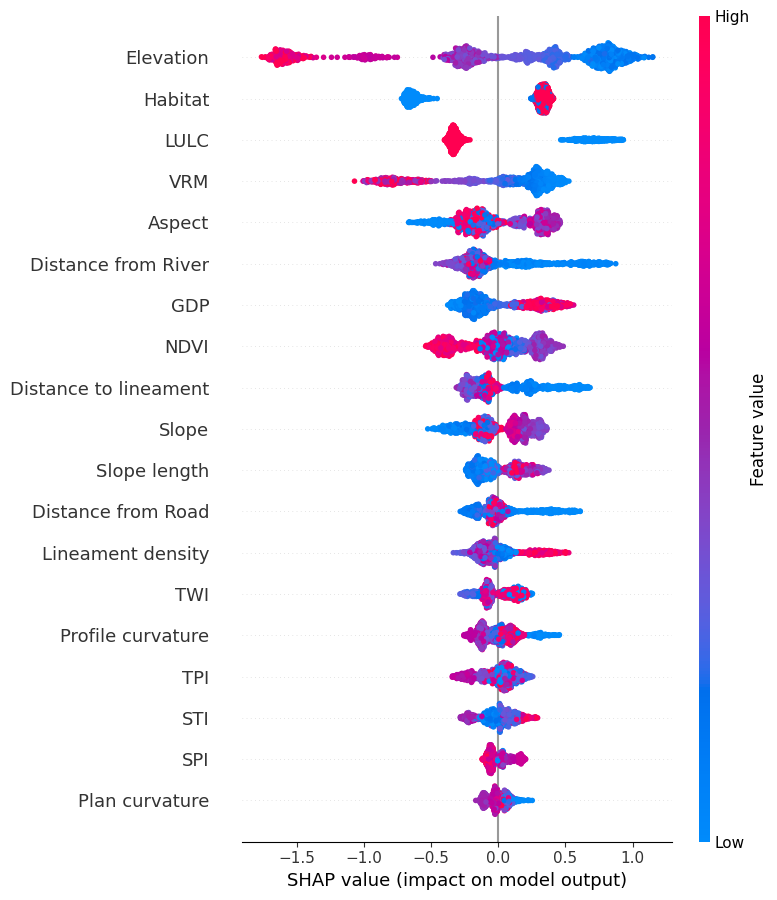

In [ ]:

# Load the pre-trained LightGBM model
light_model = joblib.load(model_path)

# Retrieve the best AUC score from the model
best_score = light_model.best_score_['valid_1']['auc']
print("******* Best Score *******")
print(best_score)

# Use SHAP (SHapley Additive exPlanations) to interpret the model's predictions
explainer = shap.TreeExplainer(light_model)  # Create SHAP explainer for the model
shap_values = explainer.shap_values(train_X)  # Calculate SHAP values for the training set

# Generate a SHAP summary plot to show feature importance
shap.summary_plot(shap_values,  # SHAP values for the positive class
                  train_X,
                  plot_type="dot",  # Dot plot type for better visualization
                  show=False,  # Do not immediately display the plot
                  sort=True,  # Sort features by importance
                  max_display=21)  # Display the top 21 features

# Print the best AUC score for reference
print("Best AUC Score:", best_score)
